In [135]:
## import packages and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import keras
import tensorflow as tf

from helper import *
from connection import *

# build training data

In [136]:
# import data
df = pd.read_csv("data/test_dataset.csv")
data = df.to_numpy()

In [137]:
(l, w) = data.shape
x_train = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = data[i, d]
        # update output array
        if p == 0: 
            x_train[i, d*2] = p # 0 score
            x_train[i, d*2+1] = p # missing indicator
        else:
            x_train[i, d*2] = p # score
            x_train[i, d*2+1] = 1-p # 1-score
x_train

array([[0.897966, 0.102034, 0.057928, 0.942072],
       [0.423429, 0.576571, 0.753434, 0.246566],
       [0.652121, 0.347879, 0.851987, 0.148013],
       ...,
       [0.833881, 0.166119, 0.354543, 0.645457],
       [0.269787, 0.730213, 0.219943, 0.780057],
       [0.501157, 0.498843, 0.775908, 0.224092]])

In [138]:
def custom_mse(y_true, y_pred):
    ground = []
    n_domain = 2
    for row in range(len(y_true)):
        new_row = []
        for i in range(n_domain):
            # if missing, then modify target
            if y_true[row, i*2] == 0 and y_true[row, i*2+1] == 0:
                new_row.append(y_pred[row, i*2])
                new_row.append(y_pred[row, i*2+1])
            else:
                new_row.append(y_true[row, i*2])
                new_row.append(y_true[row, i*2+1])
        ground.append(new_row)

    ground = tf.convert_to_tensor(ground)

    return tf.reduce_mean(tf.math.squared_difference(y_pred, ground)) # check how the gradient works in tensorflow

# Simple Autoencoder

In [139]:
## build autoencoder
from keras import layers

n_domain = w # number of domains

encoding_dim = 1
## input n_domain * 2 to represent missing values
input_layer = keras.Input(shape=(n_domain * 2,))
encode_layer = layers.Dense(encoding_dim, activation="relu")(input_layer)
decode_layer = layers.Dense(n_domain * 2, activation="sigmoid")(encode_layer)

autoencoder = keras.Model(input_layer, decode_layer)

In [140]:
# build encoder and decoder model
encoder = keras.Model(input_layer, encode_layer)
encoded_input = keras.Input(shape=(encoding_dim,))
decode_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decode_layer(encoded_input))

In [141]:
# compile with optimizer and loss function
autoencoder.compile(optimizer="adam", loss="mse")

### Training

In [142]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(x_train, test_size=0.20, random_state=42)
x_train, x_val = train_test_split(x_train, test_size=0.25, random_state=42)

In [143]:
test_case = np.array([[0, 0, 1, 0]])
test_case.shape

(1, 4)

In [144]:
x_test_encoded = encoder.predict(test_case, batch_size=256)
x_decoded = decoder.predict(x_test_encoded)

1/1 [==============================] - 0s 15ms/step


In [145]:
# custom_mse(test_case, x_decoded)

In [146]:
output = autoencoder.fit(x_train, x_train,
                epochs=500,
                validation_data=(x_val, x_val))

Epoch 1/500


10/10 [==============================] - 0s 5ms/step - loss: 0.1018 - val_loss: 0.0939
Epoch 2/500
10/10 [==============================] - 0s 2ms/step - loss: 0.1011 - val_loss: 0.0932
Epoch 3/500
10/10 [==============================] - 0s 2ms/step - loss: 0.1004 - val_loss: 0.0927
Epoch 4/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0997 - val_loss: 0.0922
Epoch 5/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0991 - val_loss: 0.0918
Epoch 6/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0986 - val_loss: 0.0913
Epoch 7/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0981 - val_loss: 0.0909
Epoch 8/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0977 - val_loss: 0.0906
Epoch 9/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0973 - val_loss: 0.0902
Epoch 10/500
10/10 [==============================] - 0s 1ms/step - loss: 0.0969 - val_loss: 0.0899
Epoch 11/500
10/10 [=

### Evaluation

In [147]:
x_test_encoded = encoder.predict(x_test, batch_size=256)

1/1 [==============================] - 0s 15ms/step


In [148]:
x_decoded = decoder.predict(x_test_encoded)

4/4 [==============================] - 0s 636us/step


In [149]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [150]:
mean_absolute_error(x_test, x_decoded, multioutput="raw_values")

array([0.209749, 0.208109, 0.113383, 0.103197])

In [151]:
mean_absolute_error(x_test, x_decoded)

0.15860926322166863

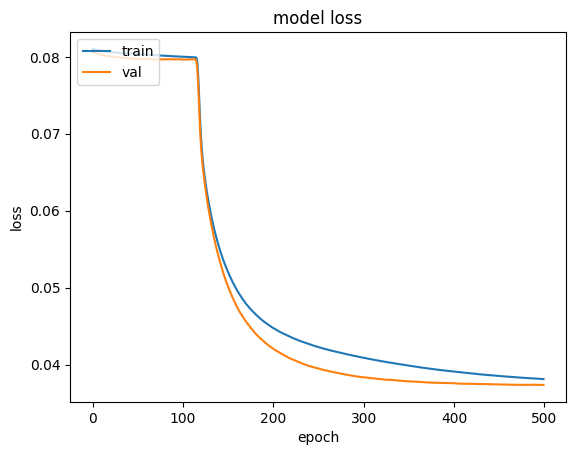

In [152]:
plt.plot(output.history['loss'])
plt.plot(output.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [153]:
## all zero test case, expecting it to return averages

all_zeros = np.zeros((1, 4))
all_zeros_encoded = encoder.predict(all_zeros)
all_zeros_decoded = decoder.predict(all_zeros_encoded)
all_zeros_decoded

1/1 [==============================] - 0s 8ms/step


array([[0.422863, 0.519536, 0.513177, 0.397293]], dtype=float32)

In [154]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
all_zeros_decoded

array([[0.422863, 0.519536, 0.513177, 0.397293]], dtype=float32)

In [155]:
x_train.mean(axis=0)

array([0.466631, 0.486703, 0.445332, 0.491335])